# Сборный Проект 2. Исследование пользовательского поведения:               
#                                   анализ воронки событий и A/A/B-тестирования.

Проект заказан стартапом, продающим продукты питания. 

##### Задача 1: Необходимо разобраться, как ведут себя пользователи мобильного приложения заказчика.

Для этого нужно            
• изучить воронку продаж,       
• узнать, как пользователи доходят до покупки;     
• сколько пользователей доходит до покупки,       
• сколько пользователе «застревает» на предыдущих шагах и на каких именно.


Кроме того дизайнеры заказчика захотели поменять шрифты во всём приложении, а менеджеры опасаются, что пользователям будет непривычно. Они договорились принять решение по результатам A/A/B-теста.    
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

##### Задача 2: Необходимо проанализировать результаты проведенного A/A/B-теста и выяснить какой шрифт лучше.
 
В случае общей аналитики и случае A/A/B-эксперимента работать нужно с одними и теми же данными, записанными в логе /datasets/logs_exp.csv . 

Каждая запись в логе — это действие пользователя, или событие. Датасет содержит следующие характеристики событий:

•	EventName — название события;             
•	DeviceIDHash — уникальный идентификатор пользователя;       
•	EventTimestamp — время события;               
•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Оглавление:

#### Шаг 1. Загрузка и общий взгляд на данные

#### Шаг 2. Подготовка данных к анализу

#### Шаг 3. Исследовательский анализ данных

#### Шаг 4. Построение воронки событий

#### Шаг 5. Изучение результатов эксперимента

#### Шаг 6. Общий вывод по результатам анализа
    

## Шаг 1. Загрузка и общий взгляд на данные

Импортируем библиотеки, которые по всей видимости будут нужны 

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth

В соответствии с описанием проекта весь имеющийся у нас набор данных расположен в одном датасете logs_exp.csv, в котором 4 столбца, названия и суть которых описана выше.

Прочтем исходный файл с данными     
(try...except для того, чтобы можно было читать файл не только локально, но и из общего хранилища). 

In [8]:
try:
    logs_exp = pd.read_csv('logs_exp.csv', sep='\t')
        
except:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

Посмотрим общую информацию о имеющихся в нашем распоряжении датафрейме:           
сколько строк в столбцах, много ли пропусков и в каких столбцах, какие у данных типы и насколько это совпадатет с сутью cамих данных.           
А так-же взглянем как выглядят "голова" и "хвост" датафрейма.

In [9]:
# задаем формат вывода столбцов полностью
pd.set_option('display.max_colwidth', False)

In [10]:
# смотрим как выглядит начало и конец датафрейма
display(logs_exp.head())
display(logs_exp.tail())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


In [11]:
# смотрим что из себя представляют данные в датафрейме
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [12]:
logs_exp.nunique()

EventName         5     
DeviceIDHash      7551  
EventTimestamp    176654
ExpId             3     
dtype: int64

In [13]:
logs_exp['ExpId'].unique()

array([246, 248, 247], dtype=int64)

In [14]:
logs_exp['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

##### Видим:

1. В датасете 4 столбца, что совпадает с описанием проекта:                 
       • EventName — название события;           
       • DeviceIDHash — уникальный идентификатор пользователя;              
       • EventTimestamp — время события;                    
       • ExpId — номер эксперимента, характеризующий разбиение пользователей по группам.
       
   Наименования столбцов не очень удобны для понимания и не соответствуют стилю. Хорошо бы поменять названия на следующие:       
       • event — название события;           
       • user — уникальный идентификатор пользователя;              
       • timestamp — время события;                    
       • group — номер эксперимента, характеризующий разбиение пользователей по группам.
       
   Кроме того хорошо было бы добавить еще и отдельный столбец с датой, чтобы не выделять каждый раз при необходимости дату из      столбца timestamp. Столбец с датой - date.

2. В датасете столбцы имеют следующие типы:                 
       • EventName — object то есть символьная строка. Это соответствует сути данных - названию события;           
       • DeviceIDHash — имеет тип целочисленного значения int64, что отражает уникальный идентификатор пользователя;             
       • EventTimestamp — тип данных показан как int64, а по сути - время события. Нужно будет поменять на DateTime. Но                  предварительно нужно разобраться в формате записи даты и времени, поскольку навскидку по виду данных, представленных в          начале и конце датафрейма понять что за таймстемпы не получается;             
       • ExpId — тип также int64, а по сути - идентификатор группы. По хорошему можно было бы заменить, однако цифровая                  идентификация группы не портит восприятия, она судя по всему привычна заказчику, му проверили - в столбце только три            значения: 246 - что соответствует группе А1, 247 - что соответствует группе А2 и 248 - что соответствует группе В. Так          что менять тип, а так-же переименовывать значения в этом столбце не будем, чтобы разговаривать впоследствии с                    заказчиком на одном языке.
        
3. Датафрейм содержит 244 тысячи 126 строк - по общему количеству событий. При этом уникальных          
       • EventName — названий событий всего 5. Это по всей видимости
               - 'MainScreenAppear' - просмотр пользователем основного экрана,
               - 'Tutorial' - просмотр пользователем страницы с руководством по использованию приложения,
               - 'OffersScreenAppear' - просмотр пользователем предложения конкрентого продукта (или группы продуктов),
               - 'CartScreenAppear' - переход пользователя корзине товаров,
               - 'PaymentScreenSuccessful' - успешное завершение пользователем оплаты товаров.
         Названия событий не соответствуют "питоновскому" стилю, однако собственно данных этот по названиям они интуитиыно                понятны, вполне различимы, понятны заказчику: так что это вполне допустимо и преобразовывать их не будем.       
       • DeviceIDHash — уникальных пользователей - 7 тысч 551 человек;              
       • EventTimestamp — время события. Их всего 176 тысяч 654 (из 244126). По всей видимости былиодновременные  события с              точностью до минуты (или до секунды). Однако однозначно с этим разобраться можно будет только посте перевода этого              столбца в "временной" формат;                    
       • ExpId — идентификатор группы - как мы уже отмечали имеет три уникальных значения, соответствующие группе в А/А/В тесте.
         В процессе предобработки данных нужно будет проверить насколько равномерно/пропорционально распределены данные по                группам.

4. В завершение заметим, что смотреть на основные численные параметры этого датафрейма при помощи метода describe() в данном        случае нет смысла, поскольку данные, которые представлены в датафрейме числами по сути являются категориальными и их числовые    параметры, которые вывоит метод describe() (среднее, медиана и т.д.) не имеют смысла.

## Шаг 2. Подготовка данных к анализу

In [15]:
display(logs_exp.head(2))
display(logs_exp.tail(2))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


,EventName,DeviceIDHash,EventTimestamp,ExpId
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


Сначала переименуем столбцы датафрейма logs_exp

In [16]:
# присваиваем столбцам новые названия
logs_exp.columns = ['event', 'user', 'timestamp', 'group']

# смотрим что получилось
logs_exp.columns

Index(['event', 'user', 'timestamp', 'group'], dtype='object')

Наименования столбцов выглядят как мы задумывали.

Теперь изменим тип данных для столбца 'timestamp'.              
Судя по тому, что данные в этом столбце имеют тип int и то, что они имеют 10 знаков и лежат в "достаточно конкретном" диапазоне (от 15640..... до 15652.....) можно предположить, что перед нами с unix-время ( то есть количество секунд, прошедших с полуночи 1 января 1970 года).        
Преобразуем  данные в тип datetime, исходя из этого предположения.

In [17]:
# преобразуем к типу datetime
logs_exp['timestamp'] = pd.to_datetime(logs_exp['timestamp'], unit='s')

# смотрим что получилось
display(logs_exp['timestamp'].dtype)
display(logs_exp.head(2))
#display(logs_exp.tail(2))

dtype('<M8[ns]')

,event,user,timestamp,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


Временные метки событий преобразованы похоже в првильный формат.            

Добавим сразу в датафрейм еще один столбец с датой события (с типом datetime)

In [18]:
# добавляем столбец с датой события
logs_exp['date'] = logs_exp['timestamp'].dt.normalize()

# смотрим что получилось
display(logs_exp['date'].dtype)
display(logs_exp.head(1))

dtype('<M8[ns]')

,event,user,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25


Со столбцами времени и даты все в порядке.           
Поскольку ранее мы договорились, что в остальных столбцах типы данных можно не преобразовывать, то считаем, что с типами данных мы разобрались.

Проверим теперь есть ли пропуски в данных

In [19]:
logs_exp.isna().sum()

event        0
user         0
timestamp    0
group        0
date         0
dtype: int64

Пропусков в данных нет.

Посмотрим есть ли дубликаты

In [20]:
logs_exp.duplicated().sum()

413

Видим, что 413 строк - это дубликаты.           
Поскольку всего у нас в датафрейме 244126 - можно считать, что на этом фоне 413 строк - это исчезающе малое количество.   
Значит их удаление не должно повлиять на общую репрезентативность выборки.

Удалим дубликаты

In [21]:
# удаляем дубликаты
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

# смотрим что получилось
print(logs_exp.duplicated().sum())
print()
logs_exp.info()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user       243713 non-null  int64         
 2   timestamp  243713 non-null  datetime64[ns]
 3   group      243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Дубликатов нет.        
В рассмотрении у нас осталось 243 тысячи 713 строк (событий).

Посмотрим как распределены данные по группам 246 (А1), 247 (А2) и 248 (В)

In [22]:
print('группа 246 = А1 -', logs_exp[logs_exp['group'] == 246].value_counts().sum(), 'событий', sep=' ')
print('группа 247 = А2 -', logs_exp[logs_exp['group'] == 247].value_counts().sum(), 'событий', sep=' ')
print('группа 248 = В  -', logs_exp[logs_exp['group'] == 248].value_counts().sum(), 'событий', sep=' ')

группа 246 = А1 - 80181 событий
группа 247 = А2 - 77950 событий
группа 248 = В  - 85582 событий


Суммарное количество событий для пользователей из групп А1, А2 и В составляет 80181 + 77950 + 85582 = 243713, что совпадает с полным количеством строк в датафрейме. Значит никаких "посторонних" данных нет.       
При этом хоть количество событий в группах и отличается, но незначительно: на 7632 масобытия максимум, то есть не более, чем на  9,8%.

###### Будем считать, что подготовку данных к анализу мы успешно завершили.

## Шаг 3. Исследовательский анализ данных

Данные у нас в датафрейме logs_exp. 

Посмотрим на его параметры.

In [23]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user       243713 non-null  int64         
 2   timestamp  243713 non-null  datetime64[ns]
 3   group      243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Можно сказать, что всего событий в наших данных 243713 и данные по ним полны (как мы уже выяснили ранее).

Посмотрим сколько уникальных значений в датафрейме: типов событий, пользователей, групп и дат проведения эксперимента.

In [24]:
logs_exp.nunique()

event        5     
user         7551  
timestamp    176654
group        3     
date         14    
dtype: int64

Эксперимент длился две недели, в нем участвовали семь с половиной тысяч пользователей, которые были разбиты на три группы.     

Типов событий 5. Посмотрим распределено общее количество событий (которое 243713) между различными типами.

In [25]:
logs_exp.groupby('event')['event'].count()

event
CartScreenAppear           42668 
MainScreenAppear           119101
OffersScreenAppear         46808 
PaymentScreenSuccessful    34118 
Tutorial                   1018  
Name: event, dtype: int64

Посмотрим так-же на количество уникальных пользователей для каждого события ...

In [26]:
logs_exp.groupby('event')['user'].nunique()

event
CartScreenAppear           3749
MainScreenAppear           7439
OffersScreenAppear         4613
PaymentScreenSuccessful    3547
Tutorial                   847 
Name: user, dtype: int64

... и посчитаем сколько в среднем событий каждого типа приходилось на одного пользователя.

In [27]:
# считаем среднее количество событий на пользователя
events_per_user = logs_exp.groupby('event')['event'].count() / logs_exp.groupby('event')['user'].nunique()

# смотрим что получилось
events_per_user

event
CartScreenAppear           11.381168
MainScreenAppear           16.010351
OffersScreenAppear         10.146976
PaymentScreenSuccessful    9.618833 
Tutorial                   1.201889 
dtype: float64

##### Таким образом:

1. Датафрейм logs с 4-мя столбцами, корректно отражающими:                  
- название события (строка),                
- числовой дентификатор пользователя,                   
- временную метку события,                 
- дату события (и время и дата - в формате datetime),                         
- и указатель группы, в которую входит пользователь (246=А1, 247=А2, 28=В).

2. В датафрейме 243713 строк без пропусков и повторов. То есть в датафрейме описаны 243 тысячи 713 различных событий/действий всех пяти типов, которые мы описывали в начале:                               
- просмотр пользователем страницы с руководством по использованию приложения (1018 событий),      
- просмотр пользователем главной страницы приложения (119101 событие),                                
- просмотр пользователем предложения конкрентого продукта или группы продуктов (46808 событий),                   
- переход пользователя на страницу своей корзины товаров (42668 событий),                   
- успешное завершение пользователем оплаты товаров из корзины (34118 событий).

3. Уникальных дат в датафрейме всего 14. То есть эксперимент (весь набор наблюдений) проводился 14 дней (кстати необязательно подряд - это нужно будет еще уточнять).          
При этом временных отметок только 176654. То есть насыщенность периода тестирования событиями была довольно высока: много (28%) событий совпали по времени до секунды.

4. Уникальных пользователей, совершивших действия/события всего 7551 человек. Поскольку общее количество событий за исследуемый период в 14 дней равно 243713, то получается, что на каждого пользователя приходится в среднем 243713 / 7551 = 32.28  события. Это представляется довольно высокой интенсивностью использования "торгового" приложения.

5. При этом 
- логично предположить, что вход в приложение начинается с главной страницы. Это дает основание сказать, что за 14 дней каждый пользователь в среднем заходил в приложение 16 раз, то есть 1.14 раза в день, что весьма неплохой показатель использования;
- среднее количество просмотров главной страницы каждым уникальным пользователем в полтора раза выше, чем других страниц ( не     считая чтения "руководства пользователя" - 16 против 9.5-11.4;
- показатели срезнего на пользователя просмотра страниц с продуктами (11.4 просмотра на пользователя), корзины выбранных           продуктов (10.2 просмотра) и успешной оплаты выбранных продуктов (9.6 просмотра) довольно близки друг к другу, что по всей       видимости дает основания говорить о хорошей конверсии по показателю "от просмотра до оплаты";
- событий чтения руководства по использованию всего чуть больше одной тысячи и среднее количество таких просмотров на             пользователя составляет всего 1.2 раза. То есть по всей видимости люди знакомимлись с инструкцией один раз ( при первом         посещении) и больше к ней не обращались.

Посмотрим теперь на период, который мы анализируем. Как мы видели он состоит из 14 дней.            
Проверим является ли этот набор дат "единым". Найдем начало и конец периода.

In [28]:
print(logs_exp['date'].min())
print(logs_exp['date'].max())
print(logs_exp['date'].max() - logs_exp['date'].min())

2019-07-25 00:00:00
2019-08-07 00:00:00
13 days 00:00:00


Таким образом имеем период проведения эксперимента без перерывов с 25 июля 2019 года по 7 августа того же года.

Посмотрим насколько равномерно распределены данные по этому периоду: сколько событий приходится на один день.

In [29]:
events_per_date = logs_exp.groupby('date')['event'].count()
events_per_date.index = events_per_date.index.date

events_per_date.head()

2019-07-25    9  
2019-07-26    31 
2019-07-27    55 
2019-07-28    105
2019-07-29    184
Name: event, dtype: int64

Визуализируем столбчатой диаграммой

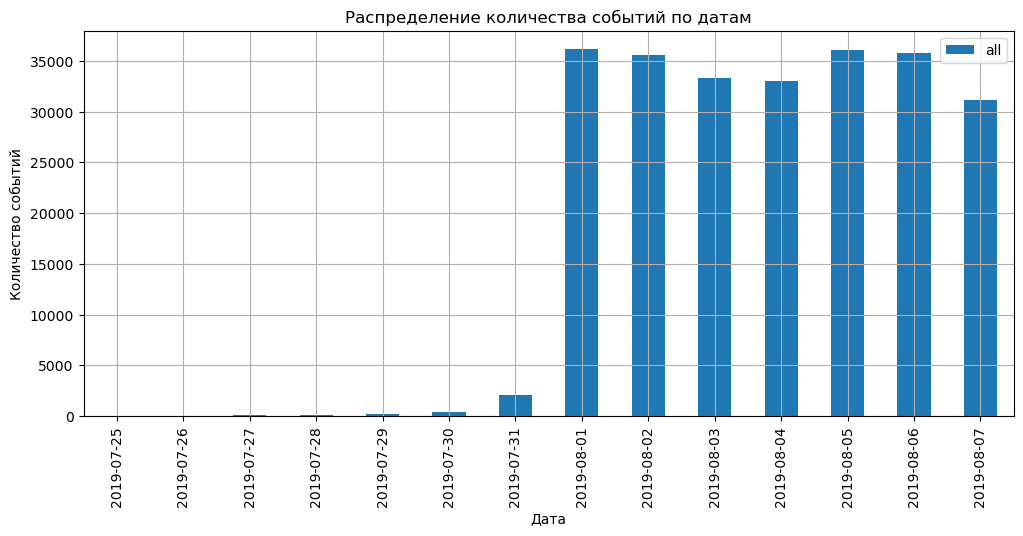

In [30]:
events_per_date.plot.bar(label='all', figsize = (12,5))
plt.grid(True)
plt.title('Распределение количества событий по датам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

###### Видим,  
что данные распределены крайне неравномерно:        
•  первая половина срока эксперимента (с 25 по 31 июля включительно) - количество данных практически нулевое,          
• а с 1 по 7 августа - по 30-35 тысяч событий в день.                  

##### Таким образом по всей видимости приходится констатировать, что первая (из) неделя проведения теста абсолютно неинформативна.

Посмотрим как распределено количество событий по группам за этот период: сколько событий приходится на каждую группу в день.

In [31]:
# делаем сводную табличку
events_per_group_daily = logs_exp.pivot_table(columns='date', index='group', values='event', aggfunc='count').fillna(0)
events_per_group_daily.columns = events_per_group_daily.columns.date

# смотрим что получилось
events_per_group_daily

,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07
group,,,,,,,,,,,,,,
246,4,14,24,33,55,129,620,11561,10946,10575,11514,12368,11726,10612
247,1,8,23,36,58,138,664,12306,10990,11024,9942,10949,11720,10091
248,4,9,8,36,71,145,746,12274,13618,11683,11512,12741,12342,10393


Визуализируем столбчатой диаграммой

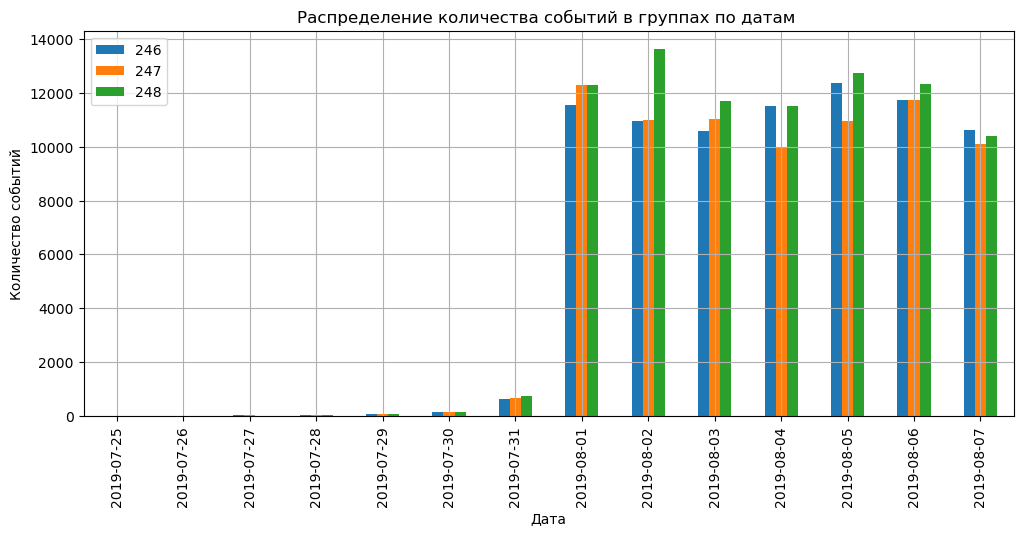

In [32]:
events_per_group_daily.T.plot.bar(figsize = (12,5))
plt.title('Распределение количества событий в группах по датам ')
plt.grid(True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

###### Видим,  
что распределение количества событий в группах столь же неравномерно, как и без разбивки на группы:        
• с 25 по 31 июля - количество данных практически нулевое,          
• с 1 по 7 августа - по 10-12 тысяч событий в день в каждой группе. При этом  распределение по группам достаточно равномерное.   

###### Таким образом подтверждается, что первая половина срока неинформативна и ее по всей видимости нужно усключать из рассмотрения.

Посмотрим еще распределение по датам событий разных типов и соотношение между ними со временем

In [33]:
events_per_type_daily = logs_exp.pivot_table(columns='date', index='event', values='timestamp', aggfunc='count').fillna(0)
events_per_type_daily.columns = events_per_type_daily.columns.date

events_per_type_daily

,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07
event,,,,,,,,,,,,,,
CartScreenAppear,2.0,6.0,4.0,24.0,23.0,49.0,257.0,6217.0,6522.0,6374.0,6155.0,6248.0,5733.0,5054.0
MainScreenAppear,4.0,16.0,39.0,53.0,132.0,279.0,1250.0,17945.0,16792.0,14832.0,15203.0,18005.0,18761.0,15790.0
OffersScreenAppear,1.0,4.0,9.0,16.0,20.0,51.0,374.0,6988.0,6924.0,6795.0,6487.0,6666.0,6533.0,5940.0
PaymentScreenSuccessful,2.0,3.0,1.0,12.0,9.0,33.0,140.0,4771.0,5148.0,5119.0,4983.0,5024.0,4631.0,4242.0
Tutorial,0.0,2.0,2.0,0.0,0.0,0.0,9.0,220.0,168.0,162.0,140.0,115.0,130.0,70.0


Визуализируем столбчатой диаграммой

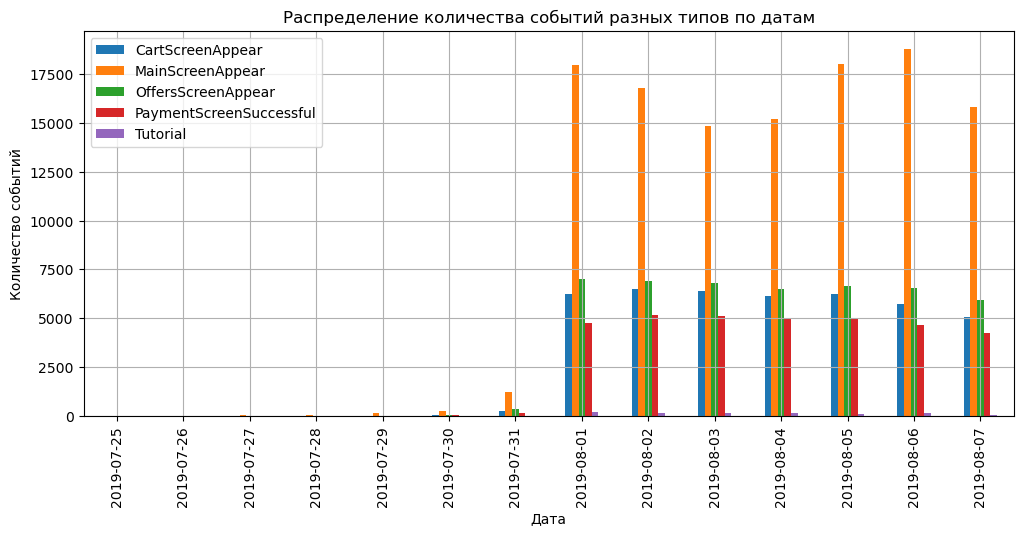

In [34]:
# формируем график
events_per_type_daily.T.plot.bar(figsize = (12,5))

# задаем параметры
plt.grid(True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий разных типов по датам')

# выводим результат
plt.show()

Соотношение между событиями разных типов во второй половине эксперимента выглядит вполне логичным: пользователи больше всего смотрят главную страницу, существенно меньше - страницу с предложениями товаров, и если уж они смотрели предложения, то они его покупали, причем преимущественно успешно. Ну а тьюториал смотрели по всей видимости только один раз и то далеко не все. 

На основании того, что мы выяснили в предыдущих пунктах - уберем из рассмотрения данные за первую неделю эксперимента - с 25 по 31 июля 2019 включительно, посмотрим достаточно ли осталось данных и если все в порядке (на что есть все шансы) - будем считать, что эксперимент проходил только неделю с 1 по 7 августа 2019 года.

In [35]:
# оставляем в рассмотрении данные только за последнюю неделю
logs_aug = logs_exp[logs_exp['date'] >= '2019-08-01']

# смотрим что получилось
display(logs_aug.head(2))
display(logs_aug.tail(2))

,event,user,timestamp,group,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01


,event,user,timestamp,group,date
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07
243712,OffersScreenAppear,5746969938801999050,2019-08-07 21:15:17,246,2019-08-07


Поскольку технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого и это может «перекашивать данные» - убедимся явным образом, что все события в полученном датафрейме logs_aug относятся к периоду с 01.08.2019 по 07.08.2019 включиетльно.

In [36]:
display( logs_aug.sort_values(by='timestamp', ascending=False)['timestamp'].min() )
display( logs_aug.sort_values(by='timestamp', ascending=False)['timestamp'].max() )

Timestamp('2019-08-01 00:07:28')

Timestamp('2019-08-07 21:15:17')

Все события находятся в нужном нам промежутке времени, судя по всему искажений быть не должно.

Посмотрим теперь на парметры полученного датафрейма.

In [37]:
logs_aug.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      240887 non-null  object        
 1   user       240887 non-null  int64         
 2   timestamp  240887 non-null  datetime64[ns]
 3   group      240887 non-null  int64         
 4   date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [38]:
logs_aug.nunique()

event        5     
user         7534  
timestamp    174044
group        3     
date         7     
dtype: int64

Посмотрим теперь сколько оказалось потерь в событиях.

In [39]:
# считаем количество потерь событий в абсолютных величинах
events_dif_abs = logs_exp['event'].count() - logs_aug['event'].count()

# считаем количество потерь событий в абсолютных величинах
events_dif_rel = round ( (logs_exp['event'].count() - logs_aug['event'].count()) / logs_exp['event'].count() , 3 )                 

print( "Абсолютные потери в количестве событий равны", events_dif_abs , "единиц", sep=" " )
print( "Относительные потери в количестве событий равны", events_dif_rel * 100, "%", sep=" " )

Абсолютные потери в количестве событий равны 2826 единиц
Относительные потери в количестве событий равны 1.2 %


Аналогично посчитаем потери в количестве уникальных пользователей.

In [40]:
# считаем количество потерь пользователей в абсолютных величинах
users_dif_abs = logs_exp['user'].nunique() - logs_aug['user'].nunique()

# считаем количество потерь пользователей в абсолютных величинах
users_dif_rel = round ( (logs_exp['user'].nunique() - logs_aug['user'].nunique()) / logs_exp['user'].nunique() , 3 )                 

print( "Абсолютные потери в количестве пользователей равны", users_dif_abs , "человек", sep=" " )
print( "Относительные потери в количестве пользователей равны", users_dif_rel * 100, "%", sep=" " )

Абсолютные потери в количестве пользователей равны 17 человек
Относительные потери в количестве пользователей равны 0.2 %


###### Таким образом

После "отсечения" первой недели у нас остается 240 тысяч 887 событий. То есть наши потери от такой "чистки" составили       
243713 - 240887 = 2826 событий или около 1.2%.  Это довольно незначительное количество, которое не должно повлиять на точность результатов анализа. Выборка из 240 тысяч событий вполне репрезетнативна, если нет сильных перекосов по группам как в отношении количества событий, так и в отношении количества пользователей.

Что касается количества пользователей, то мы видим 7534 уникальных пользователя. Это количество представляется так-же достаточно репрезентативная выборка (при условии относительно равномерного ее распределения по группам). Потери составляют всего 17 пользователей или 0.2%

В отношении количества событий - мы видели на графиках, что распределение количества событий между группами и между типами во выбранной нами части эксперимента вполне равномерное.

Убедимся теперь явным образом, что распределение количества клиентов по группам более-менее равномерное ...

In [41]:
logs_aug.groupby('group').agg({'user': ['count', 'nunique']})

user        
       count nunique
group               
246    79302  2484  
247    77022  2513  
248    84563  2537

... и что оно равномерно распределено по дням (нет явных провалов).

In [42]:
# делаем сводную табличку по группам
users_per_group_daily = logs_aug.pivot_table(columns='date', index='group', values='user', aggfunc='nunique').fillna(0)
users_per_group_daily.columns = users_per_group_daily.columns.date

# смотрим что получилось
users_per_group_daily

,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07
group,,,,,,,
246,1191,1197,1140,1170,1269,1270,1198
247,1282,1221,1176,1169,1263,1320,1212
248,1230,1229,1166,1188,1270,1332,1241


Визуализируем столбчатой диаграммой

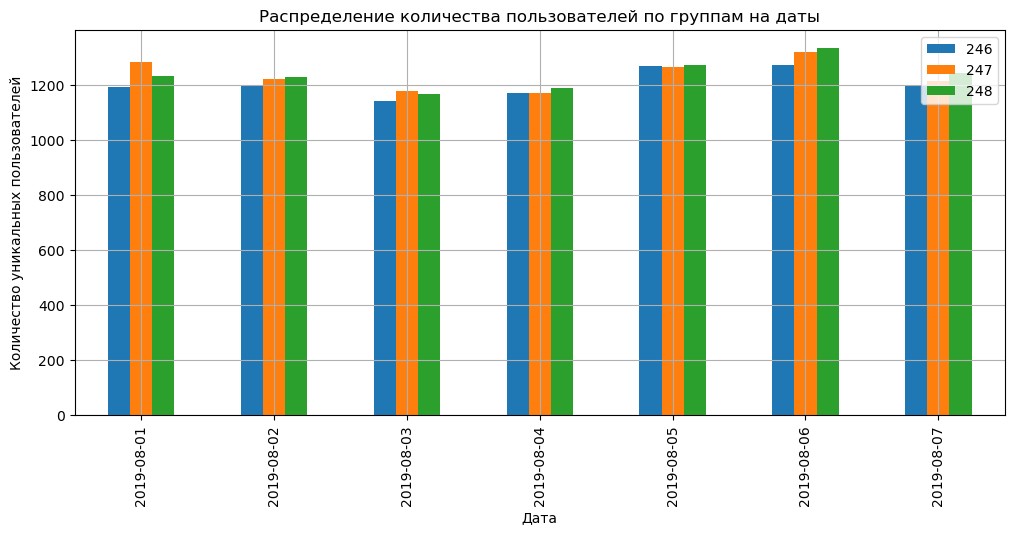

In [43]:
# формируем график
users_per_group_daily.T.plot.bar(figsize = (12,5))

# задаем параметры
plt.grid(True)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')
plt.title('Распределение количества пользователей по группам на даты')

# выводим результат
plt.show()

###### Видим

В рассматриваемый период с 1 по 7 августа ежедневно в каждой группе представлено около 1200 уникальных пользователей. Это позволяет утверждать, что выборка достаточно репрезентативна.   

При этом количество уникальных пользователей колеблется по дням в диапазоне +-100 человек, что позволяет говорить о том, что разпределение клиентов по группам в выборке весьма стабильно.

Для того, чтобы быть уверенными в результатах убедимся соблюдении еще одного условия А/В тестирования: что участники тестирования не переходят из группы в группу по ходу проведения теста.         
Для этого разобьем всех учатников по их группам, выберем уникальные сочетания группа-участник (то есть уберем повторы в этих сочетаниях) и затем посмотрим повторяются ли одни и те же участники несколько раз, то есть в разных группах. 

In [44]:
# выделяем столбцы групп и участников и оставляем только уникальные сочетания
users_cross = logs_aug[['group', 'user']].drop_duplicates()

# смотрим повторения в столбце 'user': если есть - то это количество переходов из группы в группу
users_cross['user'].duplicated().sum()

0

Как видим переходов нет - каждый клиент остается в своей группе на протяжении всего выделенного периода эксперимента.       
Значит этого влияния можно не опасаться при анализе результатов теста.

###### Будем считать, что мы готовы к дальнейшим шагам по анализу результатов эксперимента. Проводить их планируем на основе данных за вторую половину эксперимента, размещенных в датафрейе logs_aug.

## Шаг 4. Построение воронки событий

Прежде всего посмотрим картину соотношения событий разных типов и сделаем предположение о  модели клиентского поведения, то есть последовательности предпринимаемых пользователем действий (они же события в нашей терминологии).

Итак посмотрим на сами типы событий.

Как мы уже отмечали ранее различных типов событий, содержащихся в исследуемых данных представлено 5:           
    •  'Tutorial' - просмотр пользователем страницы с руководством по использованию приложения,            
    •  'MainScreenAppear' - просмотр пользователем главного экрана,               
    •  'OffersScreenAppear' - просмотр пользователем предложения конкрентого продукта (или группы продуктов),               
    •  'CartScreenAppear' - переход пользователя к корзине товаров,           
    •  'PaymentScreenSuccessful' - успешное завершение пользователем оплаты товаров из корзины.    
    

Посмотрим насколько часто встречается каждое из перечисленных типов событий суммарно за все рассматриваемые дни (данные отсортируем по убыванию частоты встречаемости).

In [45]:
# делаем сводную табличку по количеству событий разных типов
events_per_type_aug = logs_aug.groupby('event').agg({'user': 'count'}).fillna(0).sort_values(by='user', ascending=False)


events_per_type_aug

,user
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Визуализируем столбчатой диаграммой

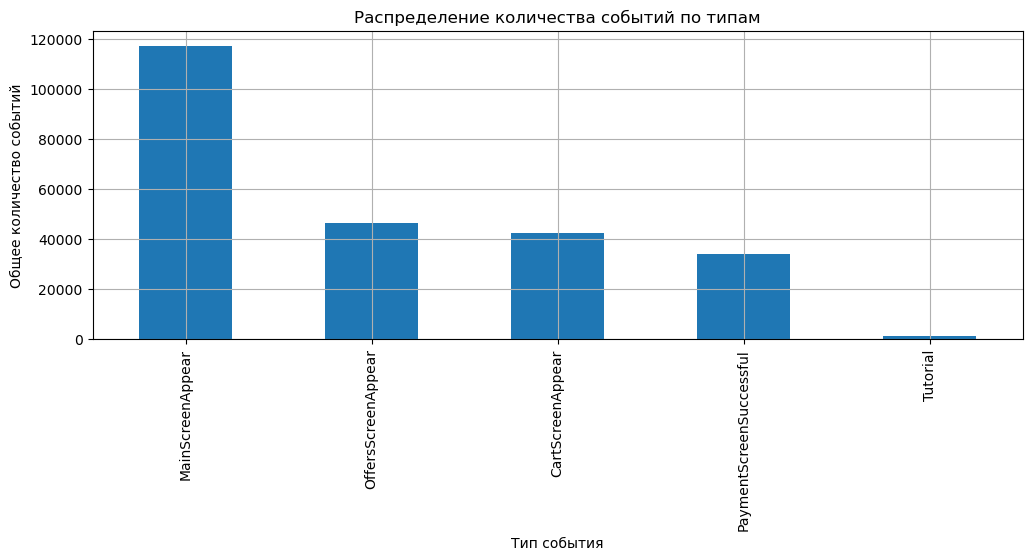

In [46]:
# формируем график
events_per_type_aug.plot.bar(figsize = (12,4), legend = False)

# задаем параметры
plt.grid(True)
plt.xlabel('Тип события')
plt.ylabel('Общее количество событий')
plt.title('Распределение количества событий по типам')

# выводим результат
plt.show()

Посмотрим теперь сколько уникальных пользователей проделывают каждое из перечисленных типов действий/событий за все рассматриваемые дни (данные отсортируем по убыванию количества пользователей)

In [47]:
# делаем табличку по количеству уникальных клиентов для разных групп событий
users_per_event_aug = logs_aug.groupby('event').agg({'user': 'nunique'}).sort_values(by='user', ascending=False)

# смотрим что получилось
users_per_event_aug

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали каждое действие/событие.

In [48]:
# считаем долю в процентах
share_per_event_aug = 100 * users_per_event_aug / logs_aug['user'].nunique()

# смотрим что получилось
share_per_event_aug

,user
event,
MainScreenAppear,98.473586
OffersScreenAppear,60.963632
CartScreenAppear,49.561986
PaymentScreenSuccessful,46.973719
Tutorial,11.149456


Для удобства выведем количество пользователей, совершивших каждое действие/событие в отдельную переменную

In [49]:
# считаем количество пользователей для каждого события
users_main = users_per_event_aug[users_per_event_aug.index == 'MainScreenAppear']['user'].sum()
users_offer = users_per_event_aug[users_per_event_aug.index == 'OffersScreenAppear']['user'].sum()
users_cart = users_per_event_aug[users_per_event_aug.index == 'CartScreenAppear']['user'].sum()
users_success = users_per_event_aug[users_per_event_aug.index == 'PaymentScreenSuccessful']['user'].sum()
users_tutorial = users_per_event_aug[users_per_event_aug.index == 'Tutorial']['user'].sum()

# смотрим что получилось
print('Находящихся на главной странице = ', users_main, 'пользователей', sep=' ')
print('Выбирающих конкретные продукты  = ', users_offer, 'пользователя', sep=' ')
print('Перешедших к корзине продуктов  = ', users_cart, 'пользователея', sep=' ')
print('Успешно  завершивших  покупку   = ', users_success, 'пользователей', sep=' ')
print('Знакомящихся с "руководством"   = ', users_tutorial, ' пользователей', sep=' ')
print()

Находящихся на главной странице =  7419 пользователей
Выбирающих конкретные продукты  =  4593 пользователя
Перешедших к корзине продуктов  =  3734 пользователея
Успешно  завершивших  покупку   =  3539 пользователей
Знакомящихся с "руководством"   =  840  пользователей



Визуализируем столбчатой диаграммой

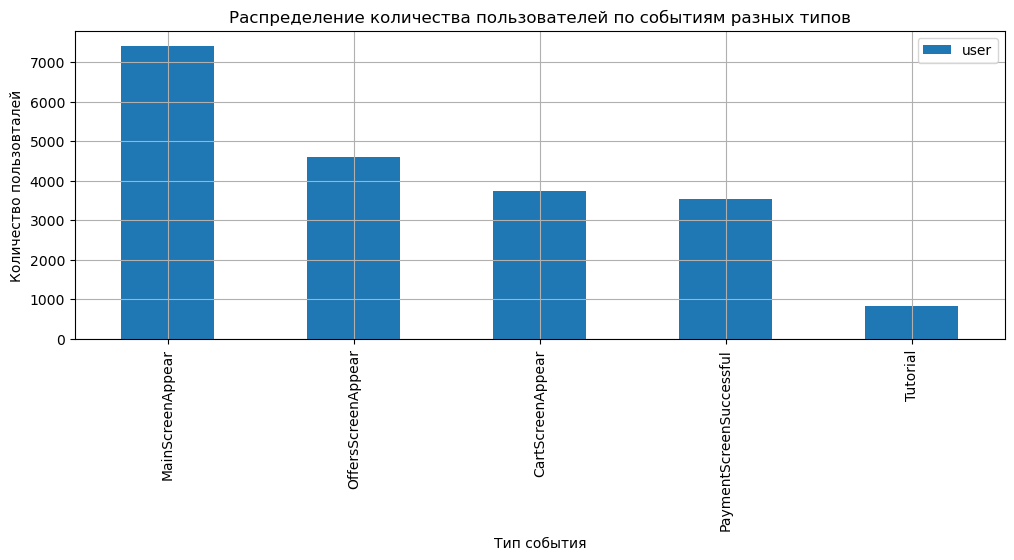

In [50]:
# формируем график
users_per_event_aug.plot.bar(figsize = (12,4))

# задаем параметры
plt.grid(True)
plt.xlabel('Тип события')
plt.ylabel('Количество пользовталей')
plt.title('Распределение количества пользователей по событиям разных типов')

# выводим результат
plt.show()

##### Выдвинем правдоподобное с нашей точки зрения предположение, что событие "Ознакомление пользователем с руковдством по использованию приложения" не входит в воронку исследуемых пользовательских действий/событий,         
поскольку по результатам анализа событий за период  с 1 по 7 августа 2019 года: 
   1. Из графика встречаемости видно, что событие "Ознакомление пользователем с руковдством по использованию приложения"  встречается гораздо реже других: только 1005 событий этого типа из суммарно 240887 событий всех типов.
   2. Из графика используемости видно, что далеко не каждый пользователь читает "руководство по использованию приложения": всего 840 уникальных пользователей из 20125 пользователей, совершивших то или иное действие/событие. Из опыта можно сказать, что потенциальный пользователь если и читает "руководство..." - то либо один раз, либо спародически "подглядывает" в него, используя как справочник.
   
То есть, будем строить воронку без учета "чтения руководства пользователя"   

По остальным типам действий/событий, по всей видимости
##### они составляют следующую последовательность или воронку: 
##### --> Первый шаг - просмотр пользователем основной страницы 
##### --> Второй шаг - просмотр страницы предложений продуктов 
##### --> Третий шаг - переход к корзине продуктов 
##### --> Четвертый шаг - успешное завершение оплаты покупки.


В этом случае редставляется возможным два вида воронок:

1. Переход от первого шага ко второму и дальше без учета реальных временных меток этих шагов.
   То есть мы предполагаем, что вход в в приложение возможен только через основную страницу и дальше пользователь имеет только      две опции (как на первом шаге так и далее): выйти или сделать следующий шаг - второй, третий и четвертый последовательно.
   В этом случае мы строим воронку просто по количеству пользователей, прошедших соответствующие шаги.

2. Переход от первого шага ко второму и дальше с учетом реальных временных меток этих шагов.
   То есть мы предполагаем, что пользователь может ходить по шагам не только "вперед", но и возвращаться по шагам назад,            выходить из приложения и затем возвращаться наместо с которого вышел и т.д.
   В этом случае нам придется строить воронку с учетом реальных сочетаний номера шага и временной отметки его совершения и          смотреть сколько пользователей переходят на следующий шаг после выполнения предыдущего.

##### Сначала построим воронку без учета временных меток каждого шага.

Количество пользователей, совершивших каждое из  событий, мы посчитали чуть выше и сохранили в отдельных переменных: users_main, users_offer, users_cart, users_success. На их основе него и будем считать доли на каждом из шагов. Первым шагом в воронке будем считать просмотр главной страницы, вторым шагом - просмотр страницы с предложением продукта, третьим - переход к корзине и последним четвертым - успешное завершение оплаты покупки.

In [51]:
# считаем долю второго шага воронки к первому
share_offer_to_main = round( 100 * users_offer / users_main , 1 ) 

# считаем долю третьего шага воронки ко второму
share_cart_to_offer = round( 100 * users_cart / users_offer , 1 ) 

# считаем долю четвертого шага воронки к третьему
share_success_to_cart = round( 100 * users_success / users_cart , 1 ) 

# смотрим что получилось
print('Находящихся на главной странице = ', 100, '%', sep=' ')
print('Выбирающих конкретные продукты  = ', share_offer_to_main, '%  от бывших на главной странице', sep=' ')
print('Перешедших к корзине продуктов  = ', share_cart_to_offer, '%  от бывших на странице предложений', sep=' ')
print('Успешно  завершивших  покупку   = ', share_success_to_cart, '%  от  бывших на странице корзины', sep=' ')
print()

Находящихся на главной странице =  100 %
Выбирающих конкретные продукты  =  61.9 %  от бывших на главной странице
Перешедших к корзине продуктов  =  81.3 %  от бывших на странице предложений
Успешно  завершивших  покупку   =  94.8 %  от  бывших на странице корзины



###### Видим

1. При переходе от первого шага воронки ко второму из 100% пользователей просматривавших основной экран приложения только 61.9% перешли к странице с конкретными предложениями товаров/продуктов. Таким образом на этом шаге "теряется" 38.1% пользователей.  Это видится вполне допустимым результатом, тем не менее это максимальные "потери" в воронке и похоже, что это должно стать основной точко приложения усилий по улучшению решения.

2. От второго шага к третьему - от просмотра конкретных продуктов к корзине заказа - переходят 81.3%, то есть потери составляют 18.7%, что представляется вполне хорошим результатом. Поскольку нет предела совершенству - здесь можно пробовать аккуратно вводить какие-нибудь небольшие изменения, но без фанатизма.

3. Из пользователей, просмотревших корзину и начавших совершать оплату успешно ее завершают 94.8%, что видится весьма позитивным результатом. В этом случае по всей видимости лучше всего "не испортить" - прилагать усилия для поддержания этого позитивного результата.

Посмотрим какая доля пользователей проходит всю воронку, то есть доходит от просмотра главной страницы до успешного завершения оплаты покупки.

In [52]:
# считаем долю четвертого шага воронки к первому
share_success_to_main = round( 100 * users_success / users_main , 1 ) 

# смотрим что получилось
print('Процент успешно завершивших оплату окупки к бывшим на главной странице = ', share_success_to_main, '%', sep=' ')
print()

Процент успешно завершивших оплату окупки к бывшим на главной странице =  47.7 %



###### Видим

что из всех пользователей, знакомящихся с главной страницей приложения упешно завершают покупку только 47.7%.         
Основная причина этого видится в низком проценте конверсии из просмотра основной страницы до выбора конкретных продуктов, который составляет около 62%.

###### В результате воронка выглядит следующим образом:

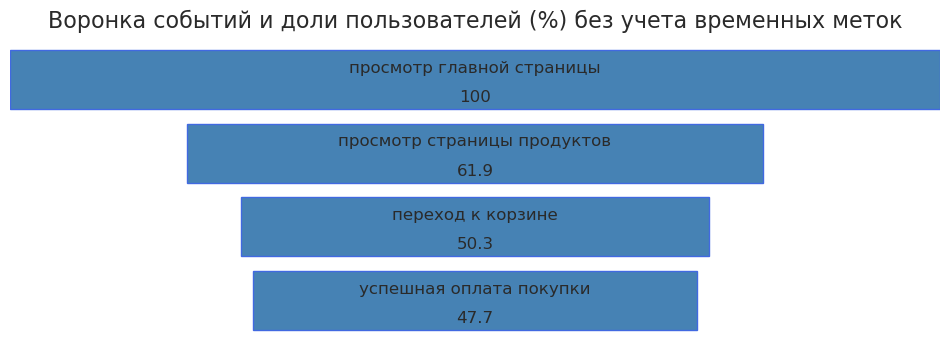

In [53]:
# задаем посчитанные ранее доли в воронке
main = 100
offer = round( 0.01 * main * share_offer_to_main , 1 )
cart = round( 0.01 * offer * share_cart_to_offer , 1 )
success = round( 0.01 * cart * share_success_to_cart, 1 )
# задаем значения для графика
y = [4,3,2,1]
x = [main, offer, cart, success]
x_max = 100
x_min = 0
x_range = x_max - x_min

labels = ['просмотр главной страницы','просмотр страницы продуктов', 'переход к корзине', 'успешная оплата покупки']

# задаем собственно изображение графика
fig, ax = plt.subplots(1, figsize=(12,4))

for idx, val in enumerate(x):
    # график
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='steelblue',
             height=.8, edgecolor='royalblue')
    # шаги воронки
    plt.text(50, y[idx]+0.1, labels[idx], ha='center', fontsize=12, color='#2A2A2A')
    # значения долей
    plt.text(50, y[idx]-0.3, x[idx], ha='center', fontsize=12, color='#2A2A2A')
    
# задаем параметры графика
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка событий и доли пользователей (%) без учета временных меток', loc='center', fontsize=16, color='#2A2A2A')

# выводим результат
print()
plt.show()
print()

Отчетливо видно, что как мы и отмечали в целом конверсия по шагам довольно высокая, за исключением второго шага - перехода от главной страницы к просмотру продуктов, на котором теряется 38.1% польователей.

##### Теперь попробуем построить воронку с учетом временных меток каждого шага.

Построение этой воронки более сложное дело, поскольку нужно учитывать не только количество пользователей на каждом шаге, но и для каждого конкретного пользователя сопоставлять время первого "прохождения" каждого шага и проверять, чтобы каждый следующий шаг был действительно пройден позже предыдущего.

В качестве основы для дальнейших расчетов создадим датафрейм, в котором для каждого пользователя будут заданы временные метки каждого события.

In [54]:
# # делаем сводную табличку по пользователям с временными метками событий
consist_steps_per_user = logs_aug.pivot_table(index='user', columns='event', values='timestamp', aggfunc='min') \
                                                           .sort_values(by='MainScreenAppear', ascending=True )
# смотрим что получилось
consist_steps_per_user

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user,,,,,
3737462046622621720,2019-08-01 13:30:20,2019-08-01 00:08:00,2019-08-01 00:08:58,2019-08-01 13:30:37,2019-08-01 00:07:28
1433840883824088890,NaT,2019-08-01 00:08:59,NaT,NaT,NaT
4899590676214355127,2019-08-01 10:04:00,2019-08-01 00:10:15,2019-08-01 00:11:30,2019-08-01 10:04:00,NaT
1182179323890311443,NaT,2019-08-01 00:11:57,NaT,NaT,NaT
4613461174774205834,2019-08-01 00:14:34,2019-08-01 00:14:31,2019-08-01 00:14:51,2019-08-01 00:14:43,NaT
...,...,...,...,...,...
8586953157808767383,2019-08-03 11:19:23,NaT,2019-08-03 11:18:46,2019-08-03 11:19:23,NaT
8804319115517716344,2019-08-02 08:50:05,NaT,2019-08-02 08:50:15,2019-08-02 08:50:04,NaT
8821171531680573201,2019-08-02 08:42:42,NaT,2019-08-02 08:42:33,2019-08-02 08:42:41,NaT


Количество уникальных пользователей будем определять соответствующим количеством строк, удовлетворяющим условию последовательности шагов.

Проверим количество пользователей на первом шаге - просмортре основной страницы приложения. Поскольку это шаг первый - то количество должно быть одинаковым для обоих типов воронок и соответственно здесь должно быть равно 7419 (как мы считали ранее)

In [55]:
# считаем количество пользователей на первом шаге
consist_users_main = consist_steps_per_user[~consist_steps_per_user['MainScreenAppear'].isna()].shape[0]


# смотрим что получилось
consist_users_main

7419

Количество уникальных пользователей на первом шаге совпадает с нашими ожиданиями. Значит по всей видимости созданная нами основа  для расчетов надежна и методика работает.

Аналогичным образом (через shape[0]) посчитаем количество пользователей на каждом шаге, так чтобы временные метки каждого следующего шага были позже (больше) меток предыдущего шага.

In [56]:
# считаем количество пользователей на каждом шаге

consist_users_offer = consist_steps_per_user[
                    (~consist_steps_per_user['MainScreenAppear'].isna()) &
                    ( consist_steps_per_user['OffersScreenAppear'] > consist_steps_per_user['MainScreenAppear'])
                                            ].shape[0] 

consist_users_cart = consist_steps_per_user[
                    (~consist_steps_per_user['MainScreenAppear'].isna()) &
                    ( consist_steps_per_user['OffersScreenAppear'] > consist_steps_per_user['MainScreenAppear']) &
                    ( consist_steps_per_user['CartScreenAppear'] > consist_steps_per_user['OffersScreenAppear'])
                                            ].shape[0]

consist_users_success = consist_steps_per_user[
                    (~consist_steps_per_user['MainScreenAppear'].isna()) &
                    ( consist_steps_per_user['OffersScreenAppear'] > consist_steps_per_user['MainScreenAppear']) &
                    ( consist_steps_per_user['CartScreenAppear'] > consist_steps_per_user['OffersScreenAppear']) &
                    ( consist_steps_per_user['PaymentScreenSuccessful'] > consist_steps_per_user['CartScreenAppear'])
                                            ].shape[0]

# смотрим что получилось
print('Находящихся на главной странице = ', consist_users_main, 'пользователей', sep=' ')
print('Выбирающих конкретные продукты  = ', consist_users_offer, 'пользователь', sep=' ')
print('Перешедших к корзине продуктов  = ', consist_users_cart, 'пользователей', sep=' ')
print('Успешно  завершивших  покупку   = ', consist_users_success, 'пользователя', sep=' ')
print()

Находящихся на главной странице =  7419 пользователей
Выбирающих конкретные продукты  =  4201 пользователь
Перешедших к корзине продуктов  =  1767 пользователей
Успешно  завершивших  покупку   =  454 пользователя



###### Видим

что с учетом временных меток событий соотношения количества клиентов на каждом из шагов выглядит совершенно иначе.

Посчитаем теперь доли пользователей, перешедших на каждый следующий шаг.

In [57]:
# считаем долю второго шага воронки к первому
consist_share_offer_to_main = round( 100 * consist_users_offer / consist_users_main , 1 ) 

# считаем долю третьего шага воронки ко второму
consist_share_cart_to_offer = round( 100 * consist_users_cart / consist_users_offer , 1 ) 

# считаем долю четвертого шага воронки к третьему
consist_share_success_to_cart = round( 100 * consist_users_success / consist_users_cart , 1 ) 

# смотрим что получилось
print('Находящихся на главной странице = ', 100, '%', sep=' ')
print('Выбирающих конкретные продукты  = ', consist_share_offer_to_main, '%  от бывших на главной странице', sep=' ')
print('Перешедших к корзине продуктов  = ', consist_share_cart_to_offer, '%  от бывших на странице предложений', sep=' ')
print('Успешно  завершивших  покупку   = ', consist_share_success_to_cart, '%  от  бывших на странице корзины', sep=' ')
print()

Находящихся на главной странице =  100 %
Выбирающих конкретные продукты  =  56.6 %  от бывших на главной странице
Перешедших к корзине продуктов  =  42.1 %  от бывших на странице предложений
Успешно  завершивших  покупку   =  25.7 %  от  бывших на странице корзины



###### Видим с учетом временных отметок последовательности событий

В общем с учетом временных отметок и последовательности шагов воронка выглядит "более проблемной", нежели так, которую мы смотрели ранее.

1. При переходе от первого шага воронки ко второму из 100% пользователей просматривавших основной экран приложения только 56.6% перешли к странице с конкретными предложениями товаров/продуктов. Таким образом на этом шаге "теряется" 43.4% пользователей. Хотя на фоне остальных этот шаг выглядит относительно "здоровым", тем не менее хорошо было бы подробнее изучить поведение клиентов в этом месте: почему просмотрев главную страницу они не знакомятся с конкретными предложениями, что является барьером. По всей видимости здесь вопрос скорее психилогический и можно придумать довольно простые методы простимулировать человека "двигаться дальше". 

2. От второго шага к третьему - от просмотра конкретных продуктов к корзине заказа - переходят 42.1%, то есть потери даже выше, чем на предыдущем шаге  и составляют 57.9%. Это значит, что чуть меньше 60% пользователей либо не находят нужный продукт, либо не уверены в его качестве или цене. Здесь есть над чем поработать продуктовикам: повнимательнее изучить соответствие ассортимента запросам клиентов, потестировать какие-то ценовые гипотезы и т.д.

3. Из пользователей, просмотревших корзину и начавших совершать оплату успешно ее завершают 25.7%, что очень мало, хотя и нейдивительно, при условии сложности и многогранности самого процесса (взаимодействие с банком и платежной системой, состояние счета пользователя в банке, различные лимиты на карте и т.д.) - сбой может произойти в массе мест. Тем не менее здесь "потери" самые высокие в воронке и по всей видимости именно на этом "тонком месте" необходимо сосредоточить максимум усилий по бесшовному и гладкому прохождению цепочки оплаты.

Посмотрим какая доля пользователей проходит всю воронку, то есть доходит от просмотра главной страницы до успешного завершения оплаты покупки.

In [58]:
# считаем долю четвертого шага воронки к первому
consist_share_success_to_main = round( 100 * consist_users_success / consist_users_main , 1 ) 

# смотрим что получилось
print('Процент успешно завершивших оплату окупки к бывшим на главной странице = ', consist_share_success_to_main, '%', sep=' ')
print()

Процент успешно завершивших оплату окупки к бывшим на главной странице =  6.1 %



###### Видим

что из всех пользователей, знакомящихся с главной страницей приложения упешно завершают покупку только чуть более 6%.         
Причина столь незначительного результата - существенные потери на каждом шаге воронки.

###### В результате воронка выглядит следующим образом:

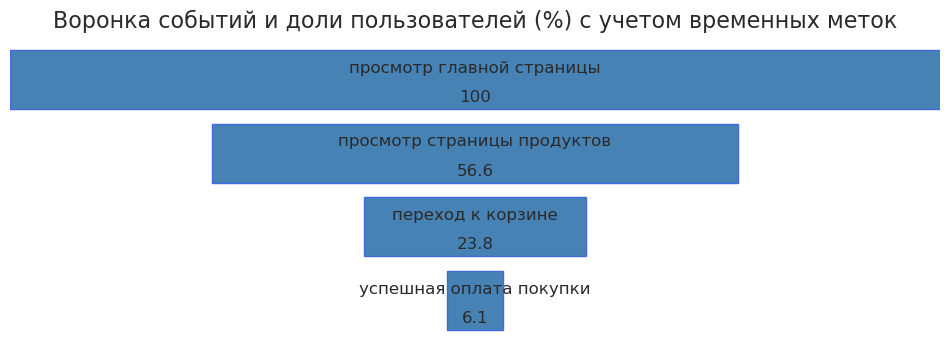

In [59]:
# задаем посчитанные ранее доли в воронке
main = 100
offer = round( 0.01 * main * consist_share_offer_to_main , 1 )
cart = round( 0.01 * offer * consist_share_cart_to_offer , 1 )
success = round( 0.01 * cart * consist_share_success_to_cart, 1 )
# задаем значения для графика
y = [4,3,2,1]
x = [main, offer, cart, success]
x_max = 100
x_min = 0
x_range = x_max - x_min

labels = ['просмотр главной страницы','просмотр страницы продуктов', 'переход к корзине', 'успешная оплата покупки']

# задаем собственно изображение графика
fig, ax = plt.subplots(1, figsize=(12,4))

for idx, val in enumerate(x):
    # график
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='steelblue',
             height=.8, edgecolor='royalblue')
    # шаги воронки
    plt.text(50, y[idx]+0.1, labels[idx], ha='center', fontsize=12, color='#2A2A2A')
    # значения долей
    plt.text(50, y[idx]-0.3, x[idx], ha='center', fontsize=12, color='#2A2A2A')
    
# задаем параметры графика
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка событий и доли пользователей (%) с учетом временных меток', loc='center', fontsize=16, color='#2A2A2A')

# выводим результат
print()
plt.show()
print()

##### Отчетливо видно, 
что если строго учитывать последовательность шагов по временным отметкам - воронка действительно получается другой,      
причем с существенно большими потерями на каждом шаге.            
Причины этих потерь имеют по всей видимости разную природу и требудт различных усилий для их устранения.

## Шаг 5. Изучение результатов эксперимента

В проводимом эксперименте пользователи были распределены по трем группам: две контрольные - 246 (А1) и 247 (А2) и одна экспериментальная 248 (В). При этом ранее мы убедились, что участники тестирования не переходят из группы в группу по ходу эксперимента.

Посмотрим (вспомним) сколько пользователей (уникальных) попадает в каждую группу.

In [60]:
users_per_group = logs_aug.groupby('group', as_index=False).agg({'user': 'nunique'})
users_per_group.columns = ['group', 'users_in_group']

users_per_group

,group,users_in_group
0,246,2484
1,247,2513
2,248,2537


В каждой группе примерно одинаковое количество пользователей - около 2.5 тысяч.

Проверим не числятся ли одни и те же пользователи более чем в одной группе. Если таковые есть - их наверное лучше убрать из рассмотрения (если их относительно немного), чтобы не искажали картину.              

Для проверки сгруппируем датафрейм logs_aug столбцу "user" и посмотрим сколько уникальных групп приходится на каждого пользователя.

In [61]:
groups_per_user = logs_aug.groupby('user', as_index=False).agg({'group': 'nunique'})
groups_per_user.sort_values(by='group', ascending=False)

display(groups_per_user['group'].max())
display(groups_per_user['group'].min())
groups_per_user.head(2)

1

1

,user,group
0,6888746892508752,1
1,6909561520679493,1


Видим,    
что количество уникальных групп для всех пользователей равно одной.              
То есть все пользователи распределены по группам без дубликатов и пересечений: каждый пользователь принадлежит только одной группе.

Поскольку суть проводимого эксперимента в том, чтобы протестировать влияние новых шрифтов, которые поменялись во всем приложении, то никакого влияния на собственно вид воронки это нововведение оказать по идее не должно.        
Возьмем за исходные данные за период с 1 по 7 августа 2019 года (из датасета logs_aug), которые мы брали для построения воронки бе привязки событий друг к другу по времени.  

Вначале посмотрим (вспомним) сколько событий каждого типа было в этот период ... 

In [62]:
events_per_type_aug

,user
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


... и сколько пользователей (уникальных) совершает каждое действие/событие.

In [63]:
users_per_event_aug

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Заметим, что самое популярное событие - это просмотр основной страницы приложения. Его посмотрели 7419 пользователей 117328 раз за неделю.   
Наименее популярное событие - это просмотр руководства пользователя приложения. Его посмотрели только 840 пользователей 1005 раз. Как мы уже заключали раньше - это событие не только самое редкое, но и не входит в воронки. Поэтому исключим его из дальнейшего рассмотрения.


На основе logs_aug сформируем новый фрейм, который для каждого типа события (кроме 'Tutorial') будет содержать количество пользователей из каждой группы, совершивших это событие и долю таких пользователей среди всех пользователей в группе.

In [64]:
# формируем датафрейм с типами событий,группами и количеством пользователей, совершивших событие
logs_aug_exp = logs_aug.groupby(['event', 'group'], as_index=False).agg({'user': 'nunique'})
logs_aug_exp.columns = ['event','group', 'users_per_event']

# убираем 'Tutorial'
logs_aug_exp = logs_aug_exp[logs_aug_exp['event'] != 'Tutorial']

# добавляем столбец с общим количеством пользователей в группах
logs_aug_exp = logs_aug_exp.merge(users_per_group,how='left', on='group')

# добавляем столбец с долей в группах пользователей, совершивших событие
logs_aug_exp['event_group_share'] = logs_aug_exp['users_per_event'] / logs_aug_exp['users_in_group']

# для удобства сортируем данные
logs_aug_exp.sort_values(by=['event','group'], ascending=True, inplace=True)

# смотрим что получилось
logs_aug_exp

,event,group,users_per_event,users_in_group,event_group_share
0,CartScreenAppear,246,1266,2484,0.509662
1,CartScreenAppear,247,1238,2513,0.492638
2,CartScreenAppear,248,1230,2537,0.484825
3,MainScreenAppear,246,2450,2484,0.986312
4,MainScreenAppear,247,2476,2513,0.985277
5,MainScreenAppear,248,2493,2537,0.982657
6,OffersScreenAppear,246,1542,2484,0.620773
7,OffersScreenAppear,247,1520,2513,0.604855
8,OffersScreenAppear,248,1531,2537,0.603469
9,PaymentScreenSuccessful,246,1200,2484,0.483092


Визуализируем долю столбчатой диаграммой

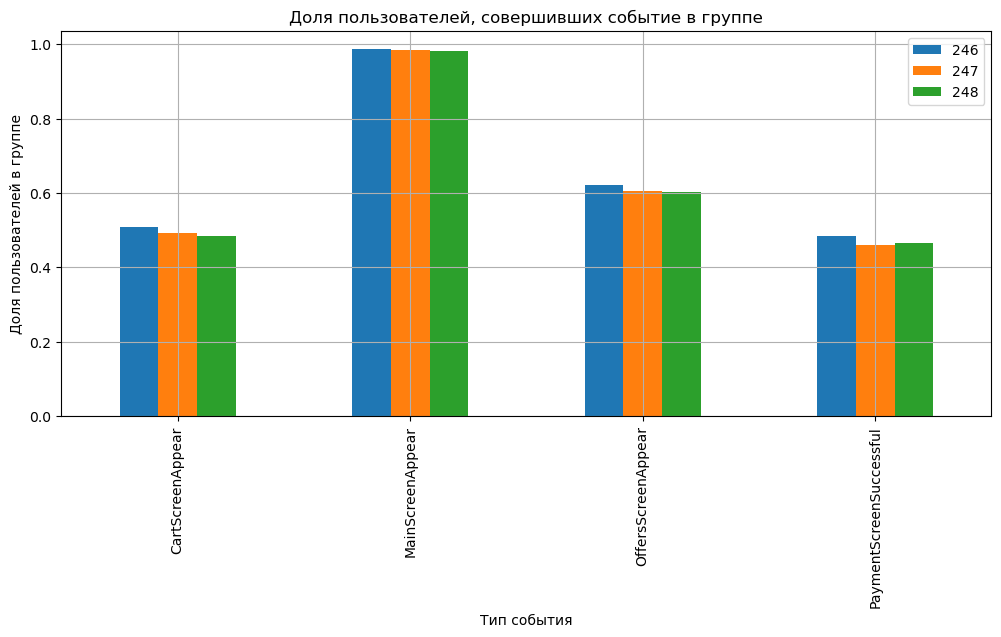

In [65]:
# формируем график
logs_aug_exp.pivot_table( index='event', columns= 'group', values = 'event_group_share').plot.bar(figsize = (12,5))

# задаем параметры
plt.grid(True)
plt.legend()
plt.xlabel('Тип события')
plt.ylabel('Доля пользователей в группе')
plt.title('Доля пользователей, совершивших событие в группе')

# выводим результат
plt.show()

###### Видим

1. Самое популярное событие действительно"просмотр основной страницы" - более 98% пользователей в каждой группе его совершают. Далее идут "просмотр страницы предоложений" - около 60% , "переход к корзине) - около 49% и "успешное завершение оплаты" - около 47% в группах.

2. Доли пользователей, совершивших то или иное действие отличаются по группам плюс минус 1%, что видится очень небольшим разбросом, однако нуждается в строгой проверке на статистическую значимость.

3. Для двух контрольных групп 246 и 247 критерии успешности А/А теста в общем соблюдаются:
    - для всех групп фиксируются одни и те же показатели,
    - количество пользователей в группах на этапе начала воронки, то есть события "просмотр основной страницы" различается на 1%
    - как мы выясняли ранее попавший в одну из групп посетитель остаётся в ней до конца теста. 

Подготовим объединенную контрольную группу (А1+А2), то есть объединим данные по группам 246 и 247 в одну, чтобы можно было рассматривать ее как единую группу. Обозначим эту группу как 245

In [66]:
# вырезаем из logs_aug_exp группы 246 и 247
logs_aug_exp_246 = logs_aug_exp[logs_aug_exp['group'].isin([246])].reset_index(drop=True)
logs_aug_exp_247 = logs_aug_exp[logs_aug_exp['group'].isin([247])].reset_index(drop=True)

# формируем новую группу 245
logs_aug_exp_245 = logs_aug_exp_246
logs_aug_exp_245.loc[:,'group'] = 245
logs_aug_exp_245.loc[:,['users_per_event', 'users_in_group']] = logs_aug_exp_246.loc[:,['users_per_event', 'users_in_group']] + \
                     logs_aug_exp_247.loc[:,['users_per_event', 'users_in_group']]
logs_aug_exp_245['event_group_share'] = logs_aug_exp_245['users_per_event'] / logs_aug_exp_245['users_in_group']

# добавляем в датафрейм logs_aug_exp
logs_aug_exp = pd.concat([logs_aug_exp, logs_aug_exp_245], ignore_index= True )

# для удобства сортируем данные 
logs_aug_exp.sort_values(by=['event','group'], ascending=True, inplace=True)

# смотрим что получилось
logs_aug_exp

,event,group,users_per_event,users_in_group,event_group_share
12,CartScreenAppear,245,2504,4997,0.501101
0,CartScreenAppear,246,1266,2484,0.509662
1,CartScreenAppear,247,1238,2513,0.492638
2,CartScreenAppear,248,1230,2537,0.484825
13,MainScreenAppear,245,4926,4997,0.985791
3,MainScreenAppear,246,2450,2484,0.986312
4,MainScreenAppear,247,2476,2513,0.985277
5,MainScreenAppear,248,2493,2537,0.982657
14,OffersScreenAppear,245,3062,4997,0.612768
6,OffersScreenAppear,246,1542,2484,0.620773


Создадим функцию проверки статистической значимости или не значимости отличий в группах.

In [67]:
# определяем функцию для статистической проверки различий

# Перед вызовом функции нужно задать требуемый критический уровень статистической значимости

def stat_validity_check (step_b, step_a, total_b, total_a):
    
    # успехи в группах
    successes = np.array([step_b, step_a])
    # попытки в группах:
    trials = np.array([total_b, total_a])
    
    # пропорция успехов в 'эксперниментальной' группе
    p_b = successes[0]/trials[0]
    
    # пропорция успехов в 'контрольной' группе
    p_a = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p_b - p_a
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # так как распределение статистики нормальное, применим метод cdf(); тест двухсторонний, поэтому саму статистику возьмём 
    # по модулю чтобы  не зависеть от её знака, по этой же причине удвоим результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # выводим значение p-value
    print('p-значение: ', p_value)

    # выводим результирующее утверждение
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть значимые различия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми")
        
print()

При помощи созданной нами выше функции выполним для выбранного уровня значимости и последовательно для каждого из событий в цепочке проверку есть ли статистически значимые различия между долями пользователей, совершивших событие от общего числа пользователей в группе для контрольных групп 247 и 246, а так-же для следующих пар экспериметальной и контрольной группы: 248 и 245, 248 и 246, 248 и 247. Суммарно проверок будет 16 для выбранного уровня значимости.

Проясним ситуацию с пороговым уровнем значимости для проверки статистических различий в группах.           
Поскольку по факту попарных сравнений экспериментальной группы 248 с тестовыми группами 245, 246 и 247 будет всего 16, то вероятность того, что хотя бы в одном из трёх попарных сравнений будет зафиксирован ложнопозитивный результат равна        
1 - (1 - alpha) ** 16 .            
То есть если мы хотим получить результирующий пороговый уровень значимости равным например 5% ( одному из "общепринятых" ), то alpha нужно взять равным не выше 0.32%

Возьмем критический уровень значимости alpha равным 0.32% и проведем проверки для каждого события.

In [68]:
alpha = 1 - (1 - 0.05) ** (1 / 16)

alpha

0.0032006977101884937

Проведем проверку на статистическую значимость различия для события "Просмотр основной страницы":

In [69]:
print()
display('Проверка различий в долях пользователей между группами для события "Просмотр основной страницы"')
print()

# проверяем группы 246 и 247
display( 'Сравнение групп 246 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 245
display( 'Сравнение групп 248 и 245')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 245)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 245)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 246
display( 'Сравнение групп 248 и 246')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 247
display( 'Сравнение групп 248 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'MainScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

'Проверка различий в долях пользователей между группами для события "Просмотр основной страницы"'

'Сравнение групп 246 и 247'

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 245'

p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 246'

p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 247'

p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



###### Видим для события "Просмотр основной страницы"        

статистическая оценка показывает, что каких-либо оснований полагать, что введение новых шрифтов повлияло на долю пользователей, совершающих это событие, нет.
          
          


Проведем проверку на статистическую значимость различия для события "Просмотр страницы предоложений":

In [70]:
print()
display('Проверка различий в долях пользователей между группами для события "Просмотр страницы предоложений"')
print()

# проверяем группы 246 и 247
display( 'Сравнение групп 246 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 245
display( 'Сравнение групп 248 и 245')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 245)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 245)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 246
display( 'Сравнение групп 248 и 246')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 247
display( 'Сравнение групп 248 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'OffersScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

'Проверка различий в долях пользователей между группами для события "Просмотр страницы предоложений"'

'Сравнение групп 246 и 247'

p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 245'

p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 246'

p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 247'

p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



###### Видим для события "Просмотр страницы предоложений"        

статистическая оценка показывает, что каких-либо оснований полагать, что введение новых шрифтов повлияло на долю пользователей, совершающих это событие, нет.


Проведем проверку на статистическую значимость различия для события "Переход к корзине продуктов":

In [71]:
print()
display('Проверка различий в долях пользователей между группами для события "Переход к корзине продуктов"')
print()

# проверяем группы 246 и 247
display( 'Сравнение групп 246 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 245
display( 'Сравнение групп 248 и 245')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 245)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 245)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 246
display( 'Сравнение групп 248 и 246')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 246)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 247
display( 'Сравнение групп 248 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'CartScreenAppear') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

'Проверка различий в долях пользователей между группами для события "Переход к корзине продуктов"'

'Сравнение групп 246 и 247'

p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 245'

p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 246'

p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 247'

p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



###### Видим для события "Переход к корзине продуктов"        

статистическая оценка показывает, что каких-либо оснований полагать, что введение новых шрифтов повлияло на долю пользователей, совершающих это событие, нет.


Проведем проверку на статистическую значимость различия для события "Успешное завершение оплаты покупки":

In [72]:
print()
display('Проверка различий в долях пользователей между группами для события "Успешное завершение оплаты покупки"')
print()

# проверяем группы 246 и 247
display( 'Сравнение групп 246 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 246)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 245
display( 'Сравнение групп 248 и 245')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 245)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 245)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 246
display( 'Сравнение групп 248 и 246')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 246)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 246)]['users_in_group']
                    )
print() 

# проверяем группы 248 и 247
display( 'Сравнение групп 248 и 247')
stat_validity_check (
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 247)]['users_per_event'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 248)]['users_in_group'], 
    logs_aug_exp.loc[(logs_aug_exp['event'] == 'PaymentScreenSuccessful') & (logs_aug_exp['group'] == 247)]['users_in_group']
                    )
print() 

'Проверка различий в долях пользователей между группами для события "Успешное завершение оплаты покупки"'

'Сравнение групп 246 и 247'

p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 245'

p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 246'

p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



'Сравнение групп 248 и 247'

p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать различия значимыми



###### Видим для события "Успешное завершение оплаты покупки"        

статистическая оценка показывает, что каких-либо оснований полагать, что введение новых шрифтов повлияло на долю пользователей, совершающих это событие, нет.



###### Таким образом

Проверка статистической значимости отличий по группам в доле пользователей, совершающих то или иное событие в воронке, среди всех пользователей в группе показала, что ни для одного события в воронке при пороговом уровне значимости каждого сопоставления alpha равном 1.5% (то есть суммарном пороговом урорвне значимости равном 4.5%) стастически значимых отличий в такой доле между экпериментальной группой 248 и контрольными группами 245, 246 и 247 нет.

Это означает, что введение новых шрифтов никак не влияет на долю пользователей совершающих то или иное событие.

## Общие выводы:

Проект заказан стартапом, продающим продукты питания.

Перед проектом были поставлены две следующие задачи:

#### Задача 1: Рразобраться, как ведут себя пользователи мобильного приложения заказчика.
Для этого нужно
• изучить воронку продаж,
• узнать, как пользователи доходят до покупки;
• сколько пользователей доходит до покупки,
• сколько пользователе «застревает» на предыдущих шагах и на каких именно.


#### Задача 2: Проанализировать результаты проведенного A/A/B-теста и выяснить какой шрифт лучше.
Дело в том, что дизайнеры заказчика захотели поменять шрифты во всём приложении, а менеджеры опасаются, что пользователям будет непривычно. Они договорились принять решение по результатам A/A/B-теста.
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.
Поэтому необходимо было провести тестирование, проанализировать его результаты и по результатам сделать заключение.


#### Компанией был предоставлен лог действий пользователяй в приложении за период с 25 июля по 7 августа 2019 года:
С этими данными нужно было работать и в случае общей аналитики и случае A/A/B-эксперимента.            
Каждая запись в логе — это действие пользователя, или событие.       

#### 1. Была проанализированы предоставленные данные:
Датасет /datasets/logs_exp.csv с данными логирования содержит следующие характеристики событий:            
• EventName — название события;               
• DeviceIDHash — уникальный идентификатор пользователя;                  
• EventTimestamp — время события;               
• ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная. 

Представленный датасет содержит информацию о 244126-и событиях/действиях, совершенных 7551-м пользователем приложения.                
В целом представленная выборка была полна и репрезентетивна. Пропусков, нестыковок и возможных ошибок не выявлено. 

#### 2. Была проведена необходимая предобработка данных для проведения анализа:
Были             
•	приведены в порядок наименовния столбцов;           
•	преобразованы типы данных в столбцах с временными метками; 
•	добывлен столбец с датами событий, рассчитанными по временным меткам;    
•	проверены и обработаны пропуски и удалены дубликаты.         


#### 3. Был проведен исследовательский анализ данных . 

###### Выявлено следующее:   

3.1 После удаления дубликатов в датафрейме осталось 243713 строк без пропусков и повторов, что остается достаточно репрезентативной выборкой. 

3.2 В датафрейме описаны события/действий всех пяти типов:
 - просмотр пользователем страницы с руководством по использованию приложения (1018 событий),
 - просмотр пользователем главной страницы приложения (119101 событие),
 - просмотр пользователем предложения конкрентого продукта или группы продуктов (46808 событий),
 - переход пользователя на страницу своей корзины товаров (42668 событий),
 - успешное завершение пользователем оплаты товаров из корзины (34118 событий).
 
3.3 Уникальных дат в датафрейме всего 14. То есть эксперимент (весь набор наблюдений) проводился 14 дней подряд (отдельно проверено).
При этом временных отметок только 176654. То есть насыщенность периода тестирования событиями была довольно высока: много (28%) событий совпали по времени до секунды.

3.4 Уникальных пользователей, совершивших действия/события 7551 человек. Поскольку общее количество событий за исследуемый период в 14 дней равно 243713, то получается, что на каждого пользователя приходится в среднем 243713 / 7551 = 32.28 события. Это представляется довольно высокой интенсивностью использования "торгового" приложения.

3.5 За время эксперимента каждый пользователь в среднем "общался" с приложением следующим образом:            
 - главную страницу приложения пользователь в среднем просматривал 16 раз, то есть 1.14 раза в день, что весьма неплохой            показатель использования;
 - среднее количество просмотров главной страницы каждым уникальным пользователем в полтора раза выше, чем других страниц ( не      считая чтения "руководства пользователя" - 16 против 9.5-11.4;
 - событий чтения руководства по использованию всего чуть больше одной тысячи и среднее количество таких просмотров на              пользователя составляет всего 1.2 раза. То есть по всей видимости люди знакомимлись с инструкцией один раз ( при первом          посещении) и больше к ней не обращались;
  - показатели среднего на пользователя просмотра остальных страниц довольно близки друг к другу:
      - страница с продуктовыми предложениями -  11.4 просмотра, 
      - корзина выбранных продуктов - 10.2 просмотра,
      - и успешной оплаты выбранных продуктов - 9.6 просмотра на пользователя.

3.6 По датам данные распределены крайне неравномерно:                
 - первая половина срока эксперимента (с 25 по 31 июля включительно) - количество данных практически нулевое,
 - а с 1 по 7 августа - по 30-35 тысяч событий в день.    
На основании этого мы убрали из рассмотрения данные за первую неделю эксперимента - с 25 по 31 июля 2019 включительно, и посчитали, что фактически эксперимент проходил только неделю с 1 по 7 августа 2019 года.          
После "отсечения" первой недели у нас остается 240 тысяч 887 событий. То есть потери от такой "чистки" составили
около 1.2%. Это довольно незначительное количество, которое не должно повлиять на точность результатов анализа.


3.7 После сокращения периода до одной  недели количество уникальных пользователей, оставшихся в рассмотрении составило 7534, то есть "ушло" из рассмотрения всего 17 человек или 0.2%. То есть по пользователям выборка осталась вполне репрезентативной. 

3.8 Пользователи распределены по трем группам: две контрольные - 246 и 247 и одна экспериментальная (те, которые пользуются новыми шрифтами) - 248-я.        
В рассматриваемый период с 1 по 7 августа ежедневно в каждой группе представлено около 1200 уникальных пользователей. Это позволяет утверждать, что выборка достаточно репрезентативна.             
При этом количество уникальных пользователей колеблется по дням в диапазоне +-100 человек, что позволяет говорить о том, что разпределение клиентов по группам в выборке весьма стабильно.            
Кроме того мы убедились, что участники тестирования не переходят из группы в группу по ходу проведения теста.


    
#### 4. Были построены две воронки событий: с учетом и без учета последовательности шагов.

4.1 Ввиду низкой популярности события "Ознакомление пользователем с руководством по использованию приложения" было выдвинуто предположение, что оно не входит в воронку исследуемых пользовательских действий/событий. Соответствеено данные об этом событии были исключены из воронки событий.

4.2 Таким образом были определены следующие события, составляющие воронку:                  
 - Первый шаг - просмотр пользователем основной страницы,              
 - Второй шаг - просмотр страницы предложений продуктов,             
 - Третий шаг - переход к корзине продуктов,                 
 - Четвертый шаг - успешное завершение оплаты покупки.                

4.3 Было предположено, что в этом случае возможны два вида воронок:                  
 - воронка первого типа - переход от первого шага ко второму и дальше без учета реальной последовательности шагов (то есть без      учета временных меток шагов воронки),              
 - воронка второго типа - переход от первого шага ко второму и дальше с учетом реальных временных меток этих шагов (частный случай воронки первого типа, становящийся актуальным в случе, если приложение сконфигурировано так, что шаги могут выполняться пользователями только последовательно).     

4.4 Была построена воронка первого типа - без учета последовательности временных меток событий. Распределение количества пользователей по шагам воронки получилось следущее:                    
 - находящихся на главной странице =  100 % (7419 человек),                
 - выбирающих конкретные продукты  =  61.9 %  от бывших на главной странице. То есть на этом шаге теряется 38.1%;         
 - перешедших к корзине продуктов  =  81.3 %  от бывших на странице предложений. Потери на этом шаге 18.7%;              
 - успешно  завершивших  покупку   =  94.8 %  от  бывших на странице корзин. Потери здесь всего 5.2%.

Таким образом по данной воронке получается, что суммарно из всех пользователей, знакомящихся с главной страницей приложения упешно завершают покупку только 47.7%.         
При этом самые значительные потери (38.1%) происходят на шаге при переходе от первого шага воронки ко второму и имеено этот переход должен стать основной точкой приложения усилий продуктовой и маркетинговой команд по улучшению приложения.            
По остальным двум шагам нужны фактически только усилия по для поддержания текущего позитивного результата.

4.6 Была построена воронка второго типа - с учетом последовательности временных меток событий. Распределение количества пользователей по шагам воронки получилось следущее:                       
 - находящихся на главной странице =  100 % (7419 человек),                
 - выбирающих конкретные продукты  =  56.6 %  от бывших на главной странице. То есть на этом шаге теряется 43.4%;         
 - перешедших к корзине продуктов  =  42.1 %  от бывших на странице предложений. Потери на этом шаге 57.9%;              
 - успешно  завершивших  покупку   =  25.7 %  от  бывших на странице корзин. Потери здесь 74.3%.
 
С учетом временных отметок и последовательности шагов воронка выглядит "более проблемной", нежели воронка первого типа. В этой воронке второго типа от первого события до последнего "доходят" только 6.1% пользователей. При этом "проблемы" каждого шага в этом случае имеют свою природу и требуют разных действий по испавлению ситуации.      


    
#### 5. Были изучены результаты эксперимента по А/А/В тестирования введения новых шрифтов в приложении.

5.1 Пользователи были разбиты на три группы: две контрольные (группы 246 и 247) и экспериментальную группу 248. В процессе изучения мы сформировали искусственную "объединенную" контрольную группу 245, состоящую из пользователей групп 246 и 247.

5.2 Самое популярное событие в группах - "просмотр основной страницы" - более 98% пользователей в каждой группе его совершают. Далее идут "просмотр страницы предоложений" - около 60% , "переход к корзине) - около 49% и "успешное завершение оплаты" - около 47% в группах.

5.3 Для контрольных групп критерии успешности А/А теста в соблюдаются:           
 - для всех групп фиксируются одни и те же показатели;                
 - количество пользователей в группах на этапе начала воронки, то есть события "просмотр основной страницы" различается на 1%;   
 - как мы специально проверили попавший в одну из групп посетитель остаётся в ней до конца теста;              
 - серия расчетов статистической значимости с пороговым уровнем значимости в 1.5% покзала, что значимых отличий в доле              конверсии по всем шагам воронки между контрольными группами нет. 
 
Таким образом мы подтвердили, что что результаты А/А теста убедительны, группы сформированы правильно, эксперимент организован корректно и результаты А/В тестирования будут валидны. 

5.4 Была проведена серия оценок результатов А/В тестирования эксперимента введения новых шрифтов в приложении.      
Результаты эксперимента тестировались отдельно       
- для каждого шага воронки первого типа,                   
- для кадой пары экспериментальная (248) группа - тестовая группа (246, 247 и "объединенная" 245).
Серия сравнений проводилась для порогового уровня статистической значимости каждого сопоставления результатов по груупам alpha равном 1.5% (то есть суммарного порогового урорвня значимости всей серии сравнений равного 4.5%).

5.5 По результатам проведенной серии сравнений можно констатировать, что что ни для одного события в воронке стастически значимых отличий между экпериментальной группой 248 и контрольными группами 245, 246 и 247 в доле пользователей, совершающих событие в воронке, среди всех пользователей в группе  нет.

##### Таким образом
Результаты тестировани показывают, что введение новых шрифтов никак не влияет на долю пользователей совершающих то или иное событие.                       
              

##### Поэтому  в качестве рекомендации можно предложить отказаться от введения в приложение новых шрифтов как  не оказывающих никакого влияния на увеличение доли пользователей, совершающих события в воронке .

#### Проект выполнил Александр Кийко.
##### a.m.kiyko@yandex.ru

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Александр, проведен основательный и подробный анализ. Все наглядно - графики и гистограммы подтверждают обоснованные выводы 👍. Успехов в обучении! 😉

</div>
